In [1]:
import lib.dataset as dataset
import lib.evaluation as ev
import lib.plotting as plot
import models

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# Read small datasets
train = 'copy_small-TRAIN.csv'
val = 'copy_small-VALIDATION.csv'
test = 'copy_small-TEST.csv'

In [47]:
model = models.inceptionV3.get_model(input_shape=(540,540,3), num_outputs=1)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [6]:
# Load weights if they were saved
save_path = 'saved_weights/no_class_weights/model.h5'

if os.path.exists(save_path):
    model.load_weights(save_path)
    print('Model loaded')

Model loaded


In [48]:
# Small training
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              #optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc', 
                       tf.keras.metrics.AUC(summation_method='minoring')]) 
                       # 'minoring' applies left summation for increasing intervals and right summation for decreasing intervals

In [49]:
cbacks = [tf.keras.callbacks.ModelCheckpoint('saved_weights/no_class_weights/best_model.h5', 
                                             monitor='val_auc_5', 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='max')]

In [50]:
history = model.fit(train_dataset.repeat(2), epochs=30, validation_data=val_dataset, callbacks=cbacks)

Epoch 1/30
232/232 [==============================] - 112s 482ms/step - loss: 3.3648 - acc: 0.8441 - auc_5: 0.8818 - val_loss: 80859.7500 - val_acc: 0.1729 - val_auc_5: 0.0000e+00
Epoch 2/30
232/232 [==============================] - 112s 484ms/step - loss: 1.3664 - acc: 0.5954 - auc_5: 0.6104 - val_loss: 38.0744 - val_acc: 0.1729 - val_auc_5: 0.1702
Epoch 3/30
232/232 [==============================] - 112s 483ms/step - loss: 1.3281 - acc: 0.5168 - auc_5: 0.4897 - val_loss: 40.0503 - val_acc: 0.1729 - val_auc_5: 0.2493
Epoch 4/30
232/232 [==============================] - 112s 482ms/step - loss: 1.1330 - acc: 0.4653 - auc_5: 0.4178 - val_loss: 22.8508 - val_acc: 0.1729 - val_auc_5: 0.1798
Epoch 5/30
232/232 [==============================] - 111s 479ms/step - loss: 1.1159 - acc: 0.5049 - auc_5: 0.4644 - val_loss: 16.6240 - val_acc: 0.1729 - val_auc_5: 0.1459
Epoch 6/30
232/232 [==============================] - 112s 484ms/step - loss: 1.0701 - acc: 0.4582 - auc_5: 0.4126 - val_loss: 0

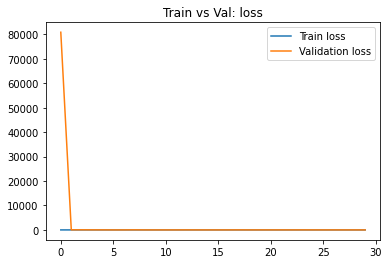

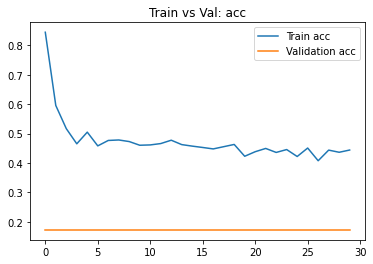

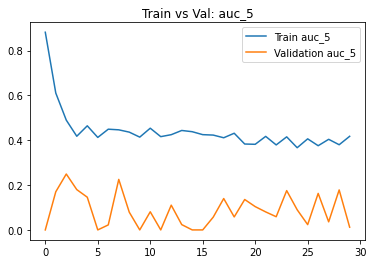

In [51]:
# Plot metrics -- CON NUEVO DATA AUGMENTATION Y CLASES BALANCEADAS
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'auc_5')

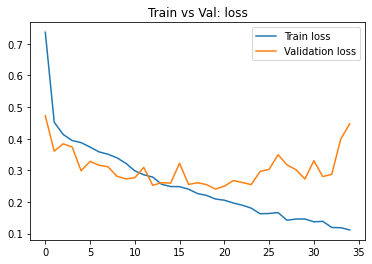

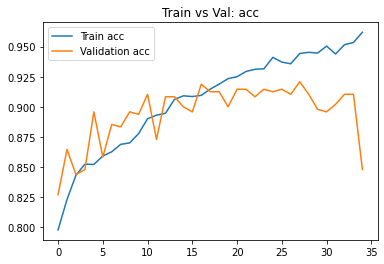

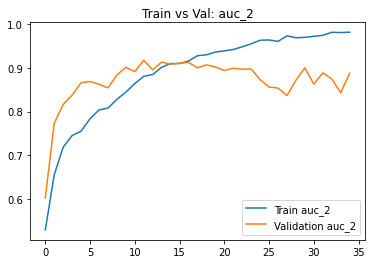

In [14]:
# Plot metrics -- CON NUEVO DATA AUGMENTATION
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'auc_2')

In [15]:
# Save model weights
model.save_weights('saved_weights/no_class_weights/model_new.h5')

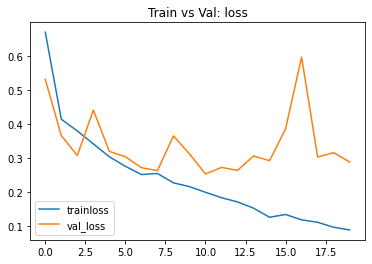

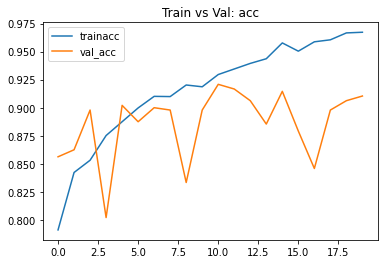

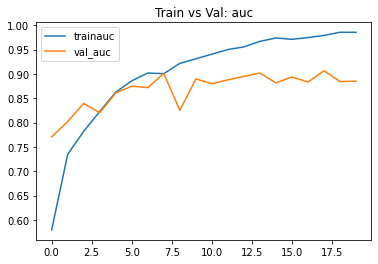

In [11]:
# Plot metrics --- ANTES CON EL ANTIGUO DATA AUGMENTATION MAS SIMPLIFICADO
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'auc')

In [8]:
# Evaluating model
model.evaluate(test_dataset)

480/480 [==============================] - 7s 15ms/step - loss: 0.3580 - acc: 0.8917 - auc: 0.8755


[0.35804030299186707, 0.8916666507720947, 0.8754737377166748]

In [16]:
# Validation predictions
y_pred_val = model.predict(val_dataset).ravel()

# Test predictions
y_pred_test = model.predict(test_dataset).ravel()

In [28]:
reload(ev)
# Get ROC curves for validation and test sets
fpr_val, tpr_val, th_val = ev.get_roc_curve(y_true_val[:,0], y_pred_val)

fpr_test, tpr_test, th_test = ev.get_roc_curve(y_true_test[:,0], y_pred_test)

# Extract values
fpr_val = fpr_val[0]
tpr_val = tpr_val[0]
th_val = th_val[0]

fpr_test = fpr_test[0]
tpr_test = tpr_test[0]
th_test = th_test[0]

# Closest point to Up-Left corner in validation dataset
val_fpr_closest, val_tpr_closest, val_thr_closest = ev.find_closest_point_to_01(fpr_val, tpr_val, th_val)

In [26]:
from importlib import reload
reload(ev)

<module 'lib.evaluation' from '/home/alumno/Escritorio/Retinopathy/lib/evaluation.py'>

In [33]:
reload(ev)
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_val)
dr_levels = dr_levels[0]
dr_classifications = dr_classifications[0]

# Sensibility operative points 
operative_points = [98, 95, 93, 90, 85]

results_val = ev.get_results_at_operative_points(fpr_val,
                                                 tpr_val,
                                                 th_val,
                                                 y_pred_val,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_points,
                                                 operative_thresholds=[[val_thr_closest]])
results_val = results_val[0]

results_val.style.set_caption("Validation dataset - Results - AUC: " + str(round(ev.get_auc(fpr_val, tpr_val), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,98.000000,25.370000,2.000000,4.920000,0.000000,0.000000,0.016535
1,95,95.000000,47.630000,5.000000,8.200000,0.000000,0.000000,0.048010
2,93,93.000000,53.470000,7.000000,13.110000,0.000000,0.000000,0.101532
3,90,90.000000,62.190000,10.000000,21.310000,0.000000,0.000000,0.227086
4,85,85.000000,76.730000,15.000000,24.590000,0.000000,0.000000,0.436342
5,Closest point,80.720000,89.170000,19.280000,24.590000,0.000000,12.500000,0.615345


In [36]:
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_test)
dr_levels = dr_levels[0]
dr_classifications = dr_classifications[0]

# Get results using thresholds of validation dataset
results_test = ev.get_results_at_operative_points(fpr_test,
                                                  tpr_test,
                                                  th_test,
                                                  y_pred_test,
                                                  dr_levels,
                                                  dr_classifications,
                                                  operative_thresholds=[[x] for x in results_val['Thresholds'].tolist()])

results_test = results_test[0]

# Add sensibility points column
results_test.insert(0, 'Sens. Operative point', results_val['Sens. Operative point'])

results_test.style.set_caption("Test dataset - Results - AUC: " + str(round(ev.get_auc(fpr_test, tpr_test), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,97.440000,25.880000,2.560000,3.700000,0.000000,0.000000,0.016535
1,95,95.190000,43.010000,4.810000,7.410000,0.000000,0.000000,0.048010
2,93,92.370000,59.590000,7.630000,9.880000,0.000000,0.000000,0.101532
3,90,87.620000,75.520000,12.380000,13.580000,0.000000,20.000000,0.227086
4,85,84.030000,85.340000,15.970000,17.280000,0.000000,30.000000,0.436342
5,Closest point,78.620000,90.700000,21.380000,22.220000,0.000000,30.000000,0.615345


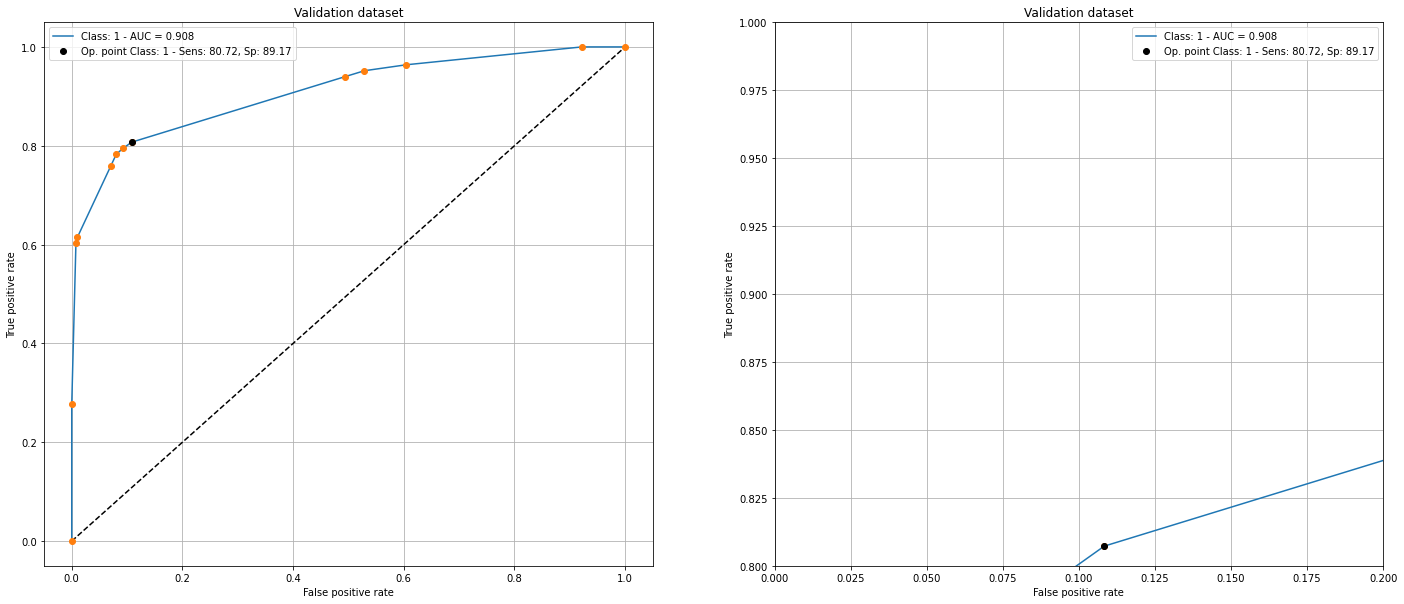

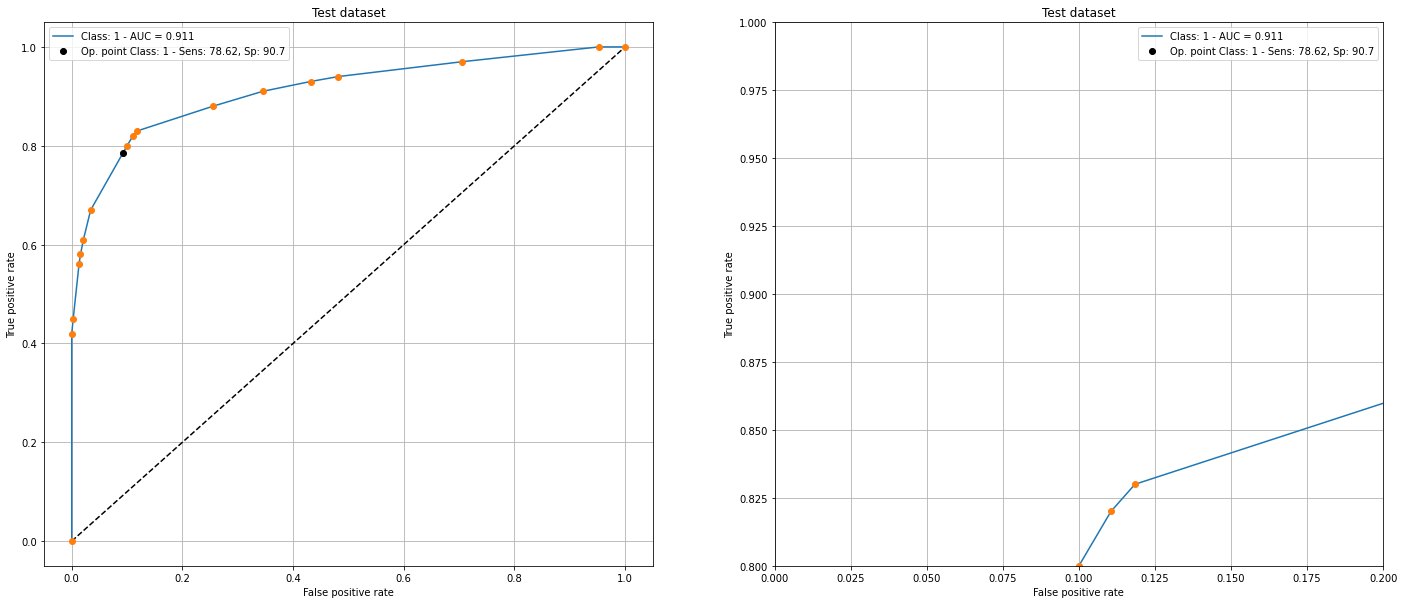

In [37]:
# Plot ROC curves -- NEW DATA AUGMENTATION
reload(plot)

plot.plot_roc_curve(fpr_val, tpr_val, th_val, 'Validation dataset', '1', grid=True, operative_threshold=None, show_points=True)

plot.plot_roc_curve(fpr_test, tpr_test, th_test, 'Test dataset', '1', grid=True, operative_threshold=val_thr_closest, show_points=True)

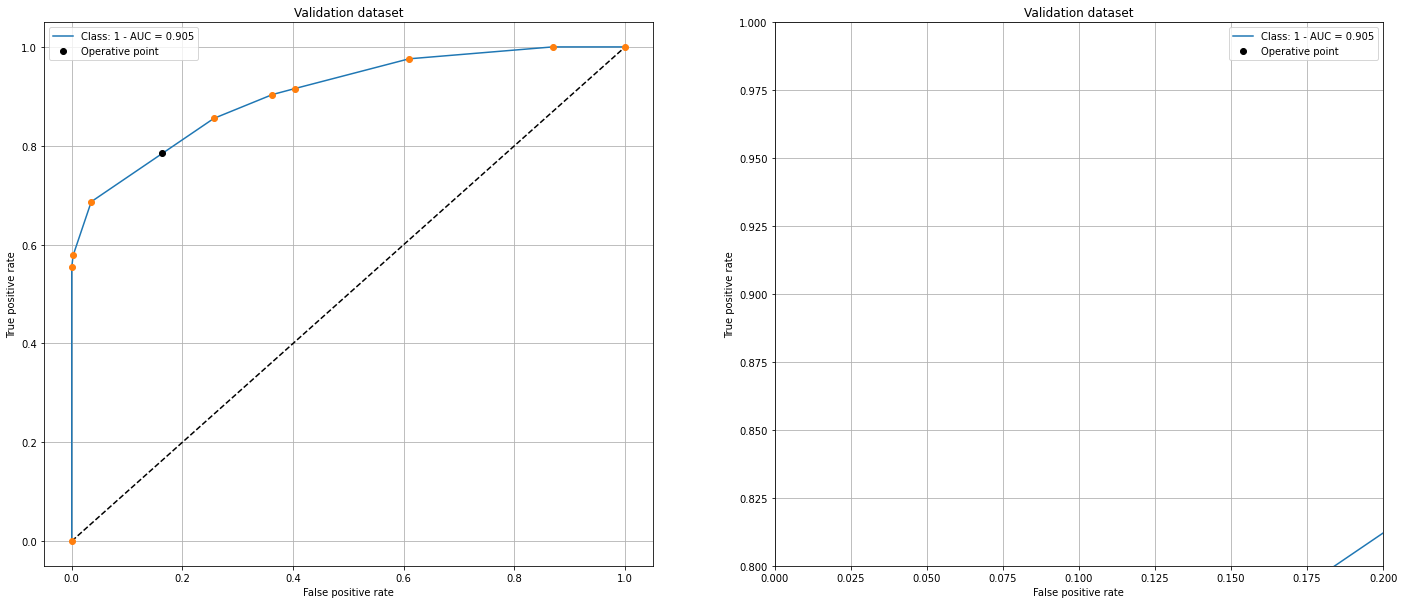

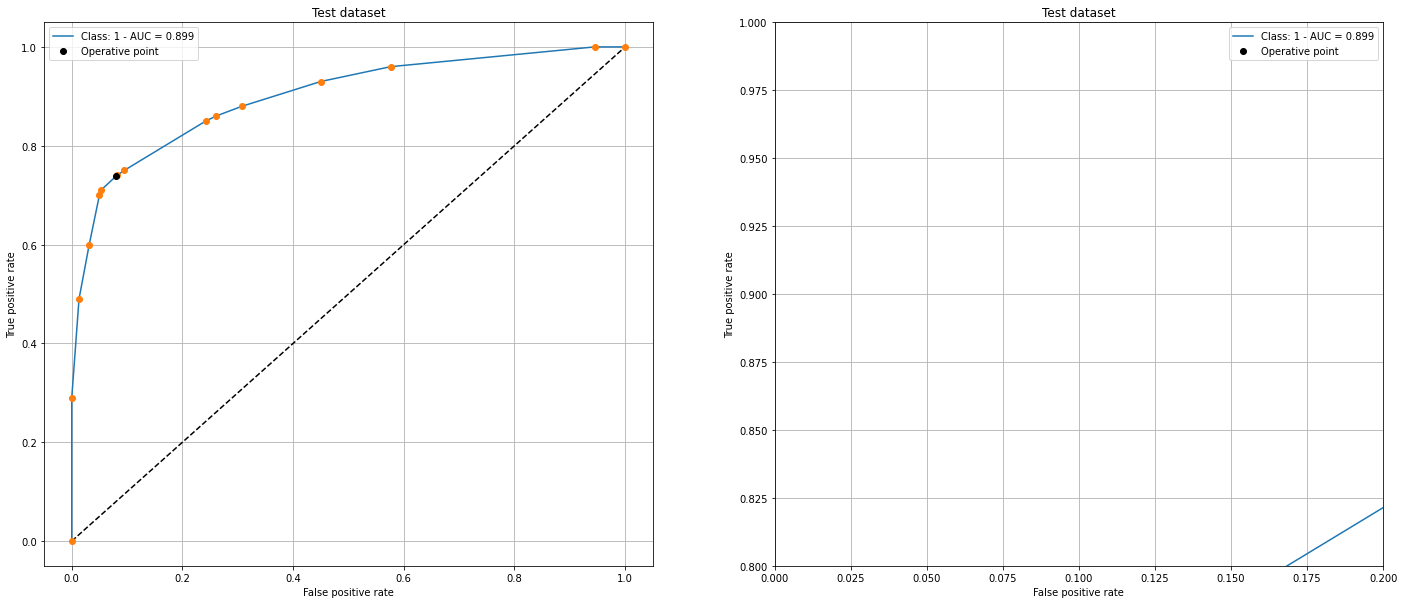

In [24]:
# Plot ROC curves
reload(plot)

plot.plot_roc_curve(fpr_val, tpr_val, th_val, 'Validation dataset', '1', grid=True, operative_threshold=None, show_points=True)

plot.plot_roc_curve(fpr_test, tpr_test, th_test, 'Test dataset', '1', grid=True, operative_threshold=val_thr_closest, show_points=True)

In [20]:
# Save model weights
model.save_weights(save_path)